In [1]:
from google.colab import drive
import zipfile, os, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
dataset = '/content/drive/MyDrive/datasets/cifake.zip'
data_path = '/content/drive/MyDrive/cifake3'
data_file = os.path.join(data_path, 'cifake.zip')

if not os.path.exists(data_path):
  os.makedirs(data_path)

with zipfile.ZipFile(data_file, 'r') as file: 
  file.extractall(data_path)

In [25]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('/content/drive/MyDrive/cifake3/cifake/train',
                                              target_size=(32, 32),
                                              batch_size=32,
                                              class_mode='categorical')

validation_generator = datagen.flow_from_directory('/content/drive/MyDrive/cifake3/cifake/valid',
                                                   target_size=(32, 32),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 4995 images belonging to 2 classes.


In [32]:
def create_patches(inputs, patch_size):
    patches = tf.image.extract_patches(images=inputs,
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, patch_size, patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patch_dim = patches.shape[-1]
    patches = tf.reshape(patches, [tf.shape(inputs)[0], -1, patch_dim])
    return patches

def patch_embedding(patches, embed_dim):
    projection = layers.Dense(embed_dim)
    embeddings = projection(patches)
    return embeddings

def add_classification_token(embeddings, embed_dim):
    batch_size = tf.shape(embeddings)[0]
    cls_token = tf.zeros((batch_size, 1, embed_dim))
    embeddings = tf.concat([cls_token, embeddings], axis=1)
    return embeddings 

def positional_embedding(sequence_length, embed_dim):
    positions = tf.range(sequence_length + 1)
    projection = layers.Embedding(sequence_length + 1, embed_dim)
    position = projection(positions)
    return position

def transformer_block(embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(sequence_length + 1, embed_dim))
    x1 = layers.LayerNormalization()(inputs)
    x2 = layers.MultiHeadAttention(num_heads, embed_dim)(x1, x1)
    x3 = layers.LayerNormalization()(inputs + x2)
    x4 = layers.Dense(embed_dim, activation='gelu')(x3)
    x5 = layers.Dense(embed_dim, activation='gelu')(x4)
    outputs = layers.LayerNormalization()(x3 + x5)
    return keras.Model(inputs=inputs, outputs=outputs)

def vision_transformer(image_size, patch_size, embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    patches = create_patches(inputs, patch_size)
    embeddings = patch_embedding(patches, embed_dim)
    embeddings = add_classification_token(embeddings, embed_dim)
    embeddings += positional_embedding(sequence_length, embed_dim)
    transformer = transformer_block(embed_dim, num_heads, sequence_length)
    x = transformer(embeddings)
    cls_token = x[:, 0]
    outputs = layers.Dense(2, activation='softmax')(cls_token)
    return keras.Model(inputs=inputs, outputs=outputs)

In [33]:
param_grid = [{'patch_size': 4, 'embed_dim': 128, 'num_heads': 4, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 6, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 256, 'num_heads': 4, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 256, 'num_heads': 6, 'sequence_length': 64},
              {'patch_size': 8, 'embed_dim': 128, 'num_heads': 4, 'sequence_length': 16},
              {'patch_size': 8, 'embed_dim': 128, 'num_heads': 6, 'sequence_length': 16},
              {'patch_size': 8, 'embed_dim': 256, 'num_heads': 4, 'sequence_length': 16},
              {'patch_size': 8, 'embed_dim': 256, 'num_heads': 6, 'sequence_length': 16}]

models = []
for params in param_grid:
    model = vision_transformer(image_size=32, **params)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    models.append(model)

In [34]:
history = []
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    hist = model.fit(train_generator,
                     steps_per_epoch=31,
                     epochs=20,
                     validation_data=validation_generator,
                     validation_steps=31)
    history.append(hist)

Training model 1
Epoch 1/20
31/31 [==============================] - 9s 96ms/step - loss: 0.7543 - acc: 0.5353 - val_loss: 0.7124 - val_acc: 0.4899
Epoch 2/20
31/31 [==============================] - 2s 81ms/step - loss: 0.7133 - acc: 0.5282 - val_loss: 0.7663 - val_acc: 0.5292
Epoch 3/20
31/31 [==============================] - 3s 89ms/step - loss: 0.6924 - acc: 0.5302 - val_loss: 0.6717 - val_acc: 0.5817
Epoch 4/20
31/31 [==============================] - 3s 87ms/step - loss: 0.6776 - acc: 0.5585 - val_loss: 0.6731 - val_acc: 0.5605
Epoch 5/20
31/31 [==============================] - 3s 82ms/step - loss: 0.6429 - acc: 0.6260 - val_loss: 0.6236 - val_acc: 0.6411
Epoch 6/20
31/31 [==============================] - 3s 85ms/step - loss: 0.6266 - acc: 0.6462 - val_loss: 0.5855 - val_acc: 0.6825
Epoch 7/20
31/31 [==============================] - 3s 86ms/step - loss: 0.6268 - acc: 0.6502 - val_loss: 0.6269 - val_acc: 0.6603
Epoch 8/20
31/31 [==============================] - 3s 95ms/step -

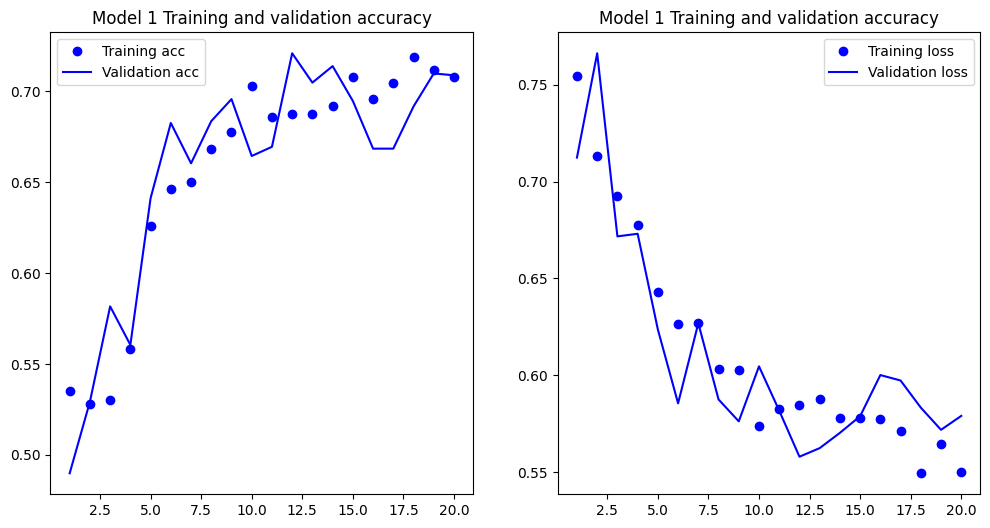

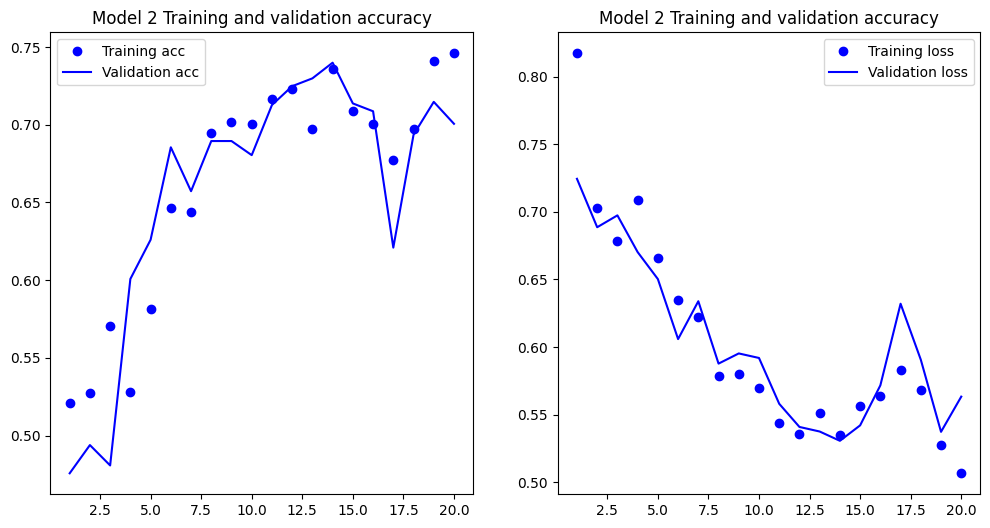

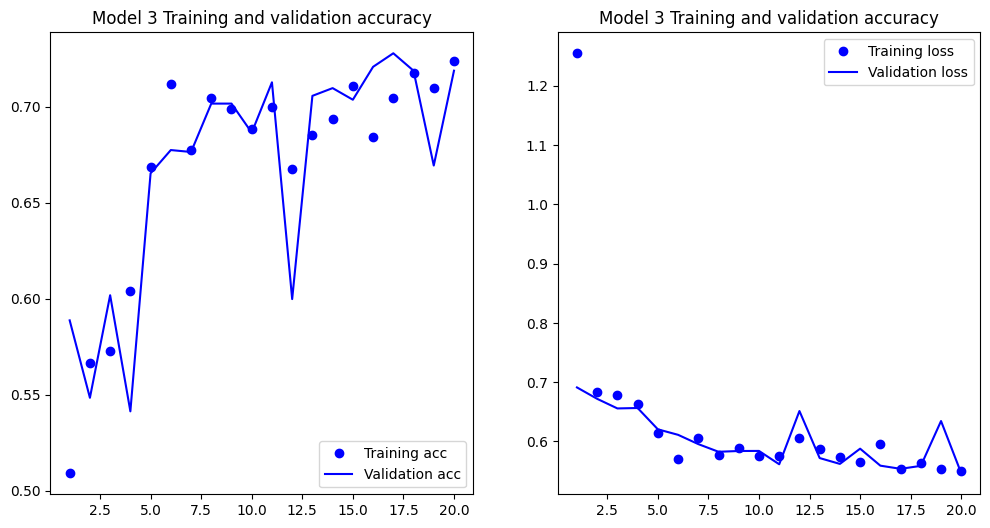

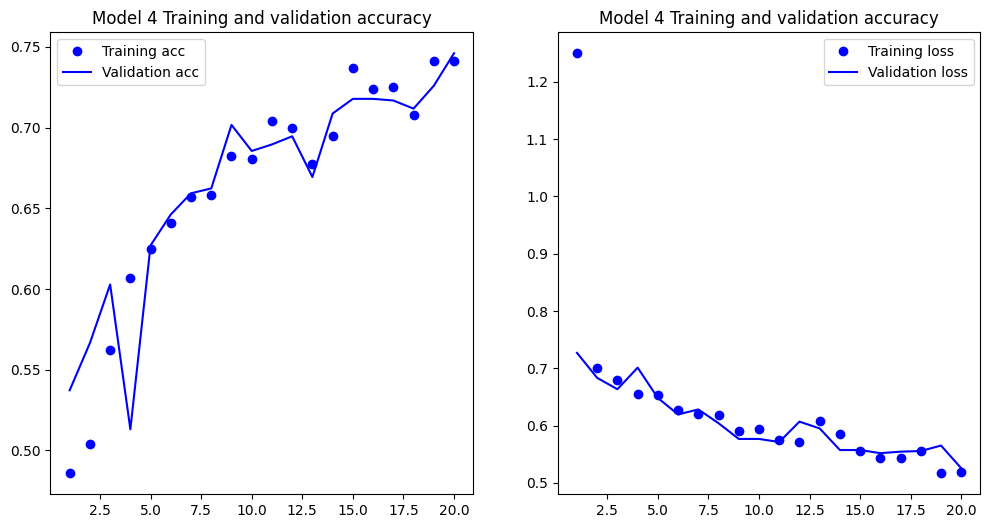

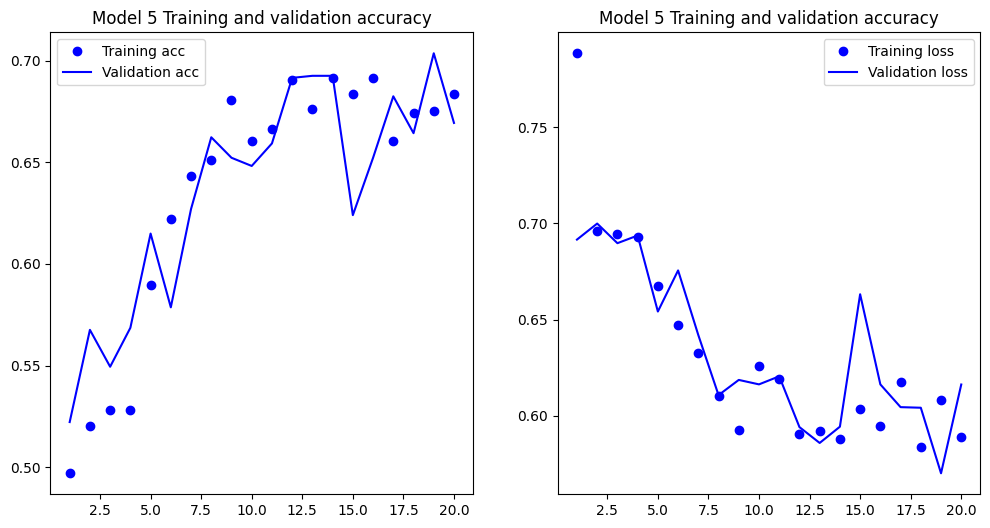

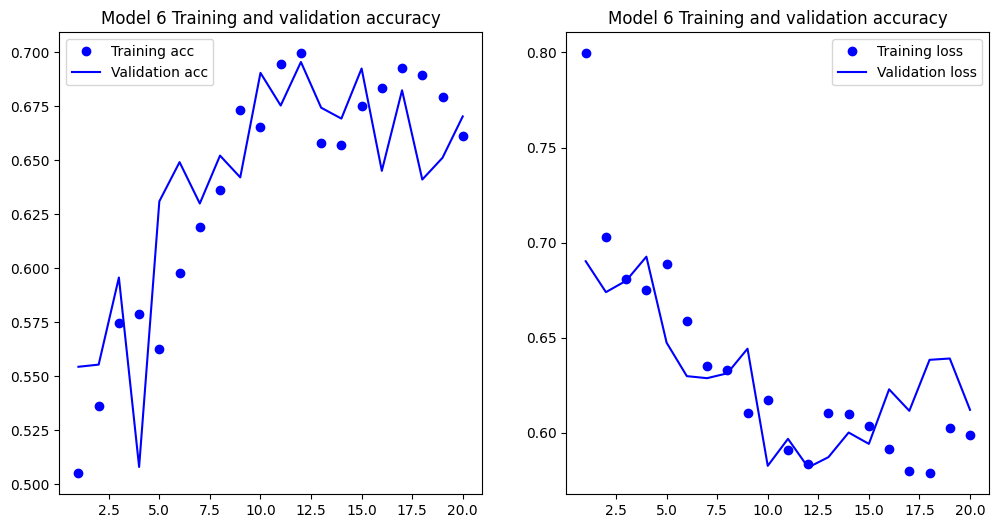

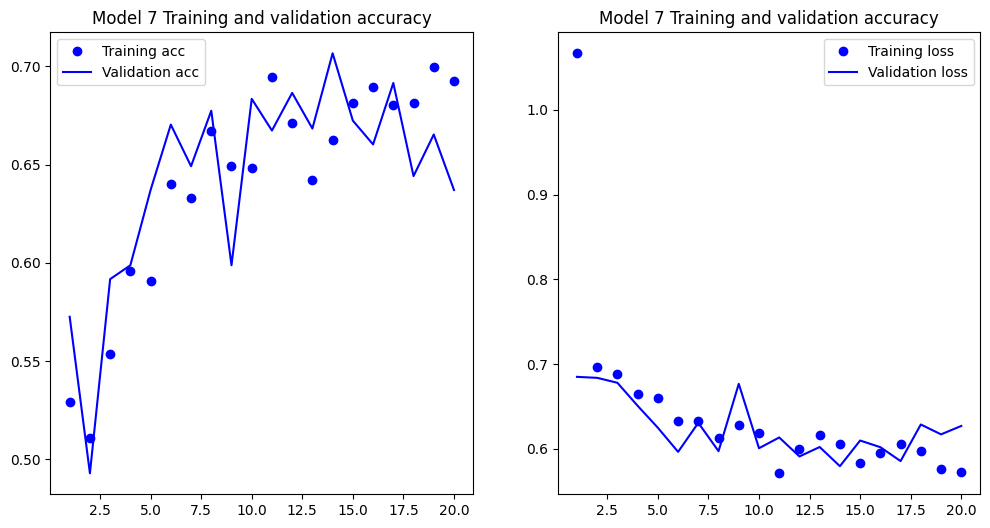

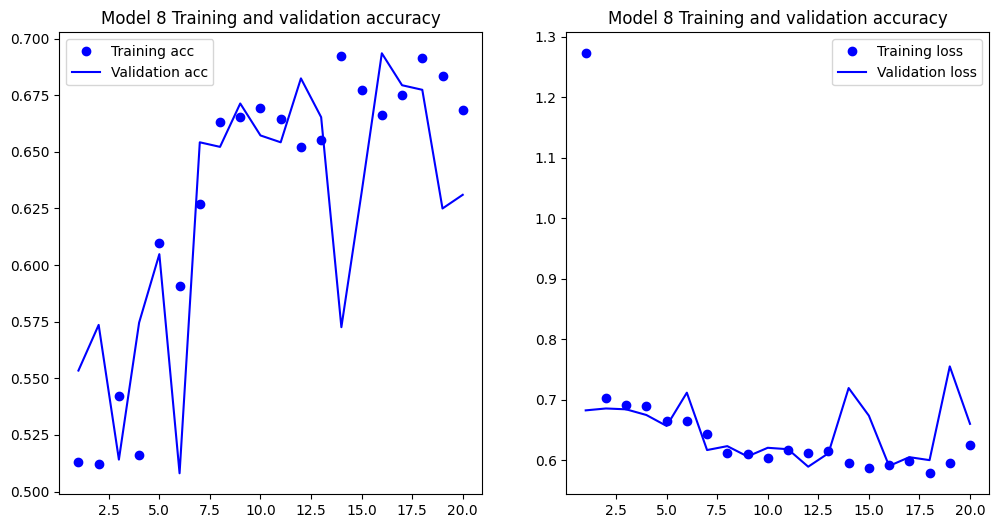

In [35]:
for i, hist in enumerate(history):
    acc = hist.history['acc'] 
    val_acc = hist.history['val_acc'] 
    loss = hist.history['loss'] 
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc, 'b', label='Validation acc') 
    plt.title("Model %d Training and validation accuracy" %(i+1))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss, 'b', label='Validation loss') 
    plt.title("Model %d Training and validation accuracy" %(i+1))
    plt.legend()

    plt.show()

In [36]:
test_generator = datagen.flow_from_directory('/content/drive/MyDrive/cifake3/cifake/test',
                                                  target_size=(32, 32),
                                                  batch_size=32,
                                                  class_mode='categorical')

for i, model in enumerate(models):
    print("Model %d evaluation" %(i+1))
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print("\n")

Found 4998 images belonging to 2 classes.
Model 1 evaluation
157/157 [==============================] - 8s 50ms/step - loss: 0.5512 - acc: 0.7179
Test accuracy: 0.7178871631622314
Test loss: 0.5511956214904785


Model 2 evaluation
157/157 [==============================] - 6s 39ms/step - loss: 0.5309 - acc: 0.7365
Test accuracy: 0.7364946007728577
Test loss: 0.5308603048324585


Model 3 evaluation
157/157 [==============================] - 7s 45ms/step - loss: 0.5295 - acc: 0.7359
Test accuracy: 0.7358943819999695
Test loss: 0.5295148491859436


Model 4 evaluation
157/157 [==============================] - 6s 41ms/step - loss: 0.5241 - acc: 0.7421
Test accuracy: 0.7420968413352966
Test loss: 0.5241442322731018


Model 5 evaluation
157/157 [==============================] - 6s 40ms/step - loss: 0.5972 - acc: 0.6823
Test accuracy: 0.6822729110717773
Test loss: 0.5972093939781189


Model 6 evaluation
157/157 [==============================] - 6s 40ms/step - loss: 0.5774 - acc: 0.6931
Test